# Intelligent Control (ECE-DK807)

## Electrical and Computer Engineering Department, University of Patras Greece

**Instructor:** Konstantinos Chazilygeroudis (costashatz@upatras.gr)

## Lab 7

### Cartpole System

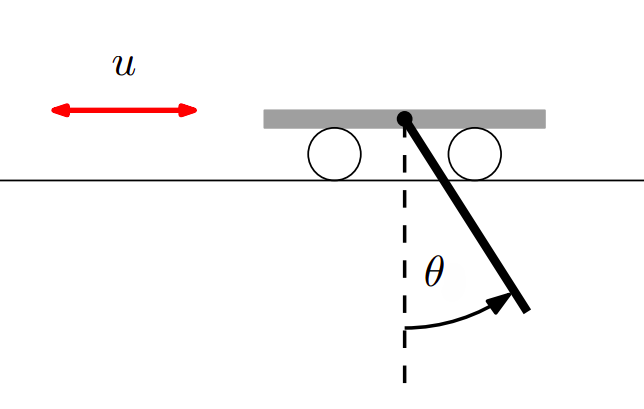

The cartpole system consists of a cart with mass $m_1$ and an attached pendulum with mass $m_2$ and length $l_p$, which swings freely in the plane.

The state of the system is $\boldsymbol{x} = \begin{bmatrix}x\\\theta\\\dot{x}\\\dot{\theta}\end{bmatrix}\in\mathbb{R}^4$ and the control input $\boldsymbol{u} = \tau\in\mathbb{R}$ is the horizontal force applied to the cart.

The dynamics are given by the following equation:

$\dot{\boldsymbol{x}} = f(\boldsymbol{x}, \boldsymbol{u}) = \begin{bmatrix}\dot{x}\\\dot{\theta}\\\frac{2m_2l_p\dot{\theta}^2\sin\theta + 3m_2g\sin\theta\cos\theta + 4\tau - 4b_f\dot{x}}{4(m_1+m_2) - 3m_2\cos^2\theta}\\\frac{-3m_2l_p\dot{\theta}^2\sin\theta\cos\theta - 6(m_1+m_2)g\sin\theta - 6(\tau-b_f\dot{x})\cos\theta}{4l_p(m_1+m_2)-3m_2l_p\cos^2\theta}\end{bmatrix}$

Let's first write down the dynamics!

In [1]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting

In [2]:
# Dynamics
def cartpole_dynamics(xx, uu):
    m1 = 0.5 # cart
    m2 = 0.5 # pole
    lp = 0.6 # length pole
    bf = 0.1 # friction
    g = 9.81 # gravity

    x = xx.reshape((4,))
    u = uu.reshape((1,))

    # x = [x,θ,\dot{x},\dot{θ}]
    # p = x[0]
    th = x[1]
    x_dot = x[2]
    th_dot = x[3]

    st = np.sin(th)
    ct = np.cos(th)

    th_dot_sq = th_dot * th_dot

    x_ddot = (2.*m2*lp*th_dot_sq*st + 3.*m2*g*st*ct + 4.*u[0] - 4.*bf*x_dot) / (4.*(m1 + m2) - 3.*m2*ct*ct)

    th_ddot = (-3.*m2*lp*th_dot_sq*st*ct - 6.*(m1+m2)*g*st - 6*(u[0]-bf*x_dot)*ct) / (4.*lp*(m1 + m2) - 3.*m2*lp*ct*ct)

    return np.array([[x_dot, th_dot, x_ddot, th_ddot]]).T

def cartpole_rk4(x, u, dt = 0.05):
    f1 = cartpole_dynamics(x, u)
    f2 = cartpole_dynamics(x + 0.5 * dt * f1, u)
    f3 = cartpole_dynamics(x + 0.5 * dt * f2, u)
    f4 = cartpole_dynamics(x + dt * f3, u)
    x_n = x + (dt/6.)*(f1 + 2. * f2 + 2. * f3 + f4)
    return x_n

In [3]:
# A few helpers
def angle_dist(b, a):
    theta = b - a
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

### Antithetic Evolution Strategy

1. Initialize $\boldsymbol{\sigma}^2_0\in\mathbb{R}^D$
2. Generate $N$ $\epsilon$-vectors ($D$-dimensional): $\boldsymbol{\epsilon}_i\sim\mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$
3. $\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})\approx\sum_{i=1}^N\frac{(J(\boldsymbol{\theta}+\sigma\boldsymbol{\epsilon}_i)-J(\boldsymbol{\theta}-\sigma\boldsymbol{\epsilon}_i))}{2\sigma}\boldsymbol{\epsilon}_i$
4. Follow the gradient with SGD or Adam
5. Compute/Adapt $\boldsymbol{\sigma}^2_{k+1}$
6. Go back to step 2 (repeat until convergence/stopping criteria)

Let's implement it to solve our cartpole system!

In [4]:
# We first need a function that generates the population
#   In essence, we need to generate N ε-vectors and fill the 2N population
#   We return the population and the ε-vectors (we need them for the gradient computation)
def generate_population(mu, sigma, N):
    ### TO-DO: Write down the function
    ### ANSWER: Insert code here
    mu = np.array(mu)
    d = mu.shape[0]
    eps = np.random.randn(d, N)
    
    pop = np.hstack([
        mu + sigma * eps,
        mu - sigma * eps
    ])
    'print(pop.shape) # -> (d, 2N)'
    ### END of ANSWER
    return pop, eps

# We evaluate the population
def evaluate_pop(pop, f):
    F = []
    # We can parallelize here!
    for i in range(pop.shape[1]):
        F.append(f(pop[:,i]))
    
    return np.array([F])

In [5]:
D = 5
mu0 = np.random.randn(D, 1)
sig0 = np.ones_like(mu0)
N = 200

pop, _ = generate_population(mu0, sig0, N)
assert(pop.shape == (5, 400))


In [6]:
# Simplest NN policy (one hidden layer!)
def policy(w, x, action_dim, hidden):
    weights = w.reshape((-1, 1))
    w1n = x.shape[0] * hidden
    b1n = hidden
    w2n = hidden * action_dim
    b2n = action_dim
    assert(weights.shape[0] == (w1n + w2n + b1n + b2n))

    ### TO-DO: Implement a Simple Neural Network
    ### We want one hidden layer with `hidden` number of hidden neurons
    ### ReLU activation for the hidden layer
    ### tanh activation for the output layer
    ### The neural network is given by the following equation: y2 = tanh(w2 @ (ReLU(w1 @ x + b1)) + b2)
    ### The weights of the neural network are stored in the input variable `w` with the following order:
    ### w = [w1, b1, w2, b2] (flattened)
    ### Store the result in a variable named `y2`
    ### ANSWER: Insert code here
    i = 0

    # 1ο layer
    w1 = weights[i:i + w1n].reshape((hidden, x.shape[0]))
    i += w1n
    b1 = weights[i:i + b1n].reshape((hidden, 1))
    i += b1n

    # 2ο layer
    w2 = weights[i:i + w2n].reshape((action_dim, hidden))
    i += w2n
    b2 = weights[i:i + b2n].reshape((action_dim, 1))
    i += b2n

    # Forward
    y1 = np.maximum(0, w1 @ x + b1) # ReLU
    y2 = np.tanh(w2 @ y1 + b2)      # tanh
    ### END of ANSWER

    return y2.reshape((-1, 1))

def policy_size(state_dim, action_dim, hidden):
    return (state_dim + 1) * hidden + (hidden + 1) * action_dim

# Helper
def transform_input(x):
    return np.array([[x[0, 0], np.cos(x[1, 0]), np.sin(x[1, 0]), x[2, 0], x[3, 0]]]).T

def policy_query(w, x, action_dim, hidden, max_action):
    ### TO-DO: Query the policy
    ### Call the function `policy` with the correct inputs. Return the output.
    ### Remember to transform the input
    ### ANSWER: Insert code here
    transformed_x = transform_input(x)
    y = policy(w, transformed_x, action_dim, hidden)

    return max_action * y;
    ### END of ANSWER

# Run episode and return cumulative reward
def episode(weights, max_steps = 80):
    state_dim, action_dim = 5, 1
    # Initial state
    x_cartpole = np.array([[0., 0., 0., 0.]]).T
    # Max torque
    max_action = 7.

    # Cumulative reward
    episode_reward = 0.

    for k in range(max_steps):
        # Query policy
        action = policy_query(weights, x_cartpole, action_dim, hidden, max_action)

        # Perform action
        next_state = cartpole_rk4(x_cartpole, action)
        # next_state[2:, :] = np.maximum(-10., np.minimum(10., next_state[2:, :]))
        reward = -10. * abs(angle_dist(np.pi, next_state[1, 0])) - next_state[0, 0]**2 - 0.01 * np.linalg.norm(next_state[2:, 0])

        x_cartpole = np.copy(next_state)
        episode_reward += reward
    return -episode_reward # our ES is minimizing!

In [7]:
# Tests
state_dim, action_dim = 5, 1
hidden = 2
max_action = 10.

w = np.ones((policy_size(state_dim, action_dim, hidden), 1))
x = -2. * np.ones((5, 1))

assert(np.isclose(policy(w, x, action_dim, hidden)[0, 0], 0.7615, rtol=1e-3, atol=1e-3))

x = 20. * np.ones((5, 1))
assert(np.isclose(policy(w, x, action_dim, hidden)[0, 0], 1., rtol=1e-3, atol=1e-3))

w[:10, :] = -1.* w[:10, :]
assert(np.isclose(policy(w, x, action_dim, hidden)[0, 0], 0.7615, rtol=1e-3, atol=1e-3))

for _ in range(100):
    x = np.random.randn(5, 1)
    v = policy(w, x, action_dim, hidden)[0, 0]
    assert(v >= -1. and v <= 1.)

x = np.ones((4, 1))
policy_query(w, x, action_dim, hidden, max_action);

In [8]:
def antithetic_es_gradient(F, mu, sigma, eps, N):
    F = np.asarray(F).flatten()
    sigma = np.asarray(sigma).reshape(-1, 1)

    if F.size == 2 * N:
        F_plus = F[:N].reshape(1, N)
        F_minus = F[N:].reshape(1, N)
        eps_used = eps[:, :N]

        grad = (eps_used @ (F_plus - F_minus).T) / (2 * N * sigma)
    elif F.size == N:
        ' https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html '
        temp = np.concatenate([F, F]).reshape(2 * N, 1)
        
        grad = (eps @ temp) / (2 * N * sigma)

    return grad;

In [9]:
# Tests
np.random.seed(5)

mu0 = np.random.randn(4, 1)
sig0 = np.random.randn(4, 1)
N0 = 1
f0 = np.random.randn(N0)
eps0 = np.random.randn(4, 2 * N0)

dx = antithetic_es_gradient(f0, mu0, sig0, eps0, N0)

assert(np.isclose(dx, np.array([[-1.30303608], [-0.03341366], [0.10949152], [-0.07153784]]), rtol=1e-3, atol=1e-3).all())

mu0 = np.random.randn(4, 1)
sig0 = np.random.randn(4, 1)
N0 = 1
f0 = np.random.randn(N0)
eps0 = np.random.randn(4, 2 * N0)

dx = antithetic_es_gradient(f0, mu0, sig0, eps0, N0)

assert(np.isclose(dx, np.array([[0.12644803], [0.04193474], [-0.136143], [-0.03834456]]), rtol=1e-3, atol=1e-3).all())

In [10]:
def antithetic_es_iteration():
    global mu, sigma, N, m, v, b1a, b2a, all_bests
    # Generate population
    pop, eps = generate_population(mu, sigma, N)
    
    # Evaluate population
    F = evaluate_pop(pop, episode)
    
    # Compute gradient estimation
    dx = antithetic_es_gradient(F, mu, sigma, eps, N)
    
    # Adam Update
    m = b1*m+(1-b1)*dx
    v = b2*v+(1-b2)*np.square(dx)
    a = lr*np.sqrt(1.-b2a)/(1.-b1a)
    
    # Step optimization
    mu = mu - a*m/(np.sqrt(v)+epsilon)
    # Adapt sigma
    sigma = sigma * 0.9999
    
    # Adam Update #2
    b1a *= b1
    b2a *= b2
    
    mu_f = episode(mu)
    # print(np.mean(F))
    # print(np.min(F))
    # print(mu_f)
    # print(np.mean(sigma))
    # print(mu_f)
    
    # all_bests += [-np.min(F)]
    all_bests += [-mu_f]

In [11]:
# Print iterations progress
def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [12]:
# Antithetic ES
lr = 1e-3 # learning rate
N = 5 # population

state_dim, action_dim = 5, 1
hidden = 10

# Initial mu, sigma
mu = np.random.randn(policy_size(state_dim, action_dim, hidden), 1)
sigma = np.ones_like(mu)

# For Adam
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
b1a = b1
b2a = b2

m = np.zeros(mu.shape)
v = np.zeros(mu.shape)

# For plotting
all_bests = []

In [13]:
max_iters = 2000
for it in range(max_iters):
    antithetic_es_iteration()
    printProgressBar(it, max_iters-1, str(-all_bests[-1]))

2100.6412990375143 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


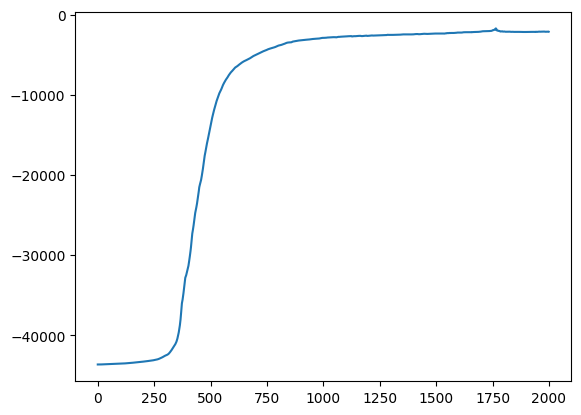

In [14]:
# Plot learning
fig, ax = plt.subplots(1, 1)

xx = np.arange(len(all_bests))

ax.plot(xx, all_bests)

plt.show()

2100.6412990375143


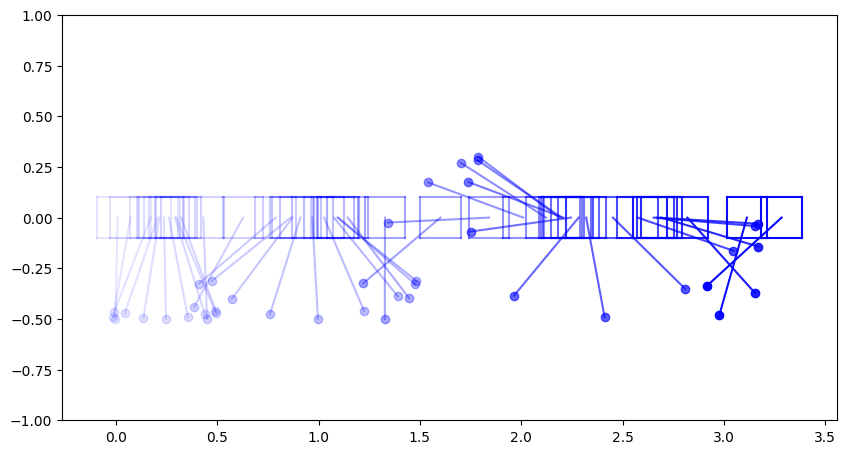

In [15]:
# Visualize solution
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
plt.cla()
ax.set_aspect('equal', 'box')

weights = mu # The mean is the optimized parameters in Antithetic ES!
max_steps = 80
# Initial state
x_cartpole = np.array([[0., 0., 0., 0.]]).T
# Max torque
max_action = 7.

# Cumulative reward
episode_reward = 0.
start_alpha = 0.1
final_alpha = 1.

for k in range(max_steps):
    action = policy_query(weights, x_cartpole, action_dim, hidden, max_action)

    # Perform action
    next_state = cartpole_rk4(x_cartpole, action)
    # next_state[2:, :] = np.maximum(-10., np.minimum(10., next_state[2:, :]))
    reward = -10. * abs(angle_dist(np.pi, next_state[1, 0])) - next_state[0, 0]**2 - 0.01 * np.linalg.norm(next_state[2:, 0])

    # Render
    if k % 2 == 0 or k == max_steps - 1:
        alpha = start_alpha * np.power(final_alpha / start_alpha, float(k)  / float(max_steps))
        # Set limts
        # plt.xlim(-1., 1.)
        plt.ylim(-1., 1.)
    
        # plot base
        x = next_state[0, 0]
        ax.plot([x - 0.1, x + 0.1], [-0.1, -0.1], 'b', alpha=alpha)
        ax.plot([x - 0.1, x - 0.1], [-0.1, 0.1], 'b', alpha=alpha)
        ax.plot([x - 0.1, x + 0.1], [0.1, 0.1], 'b', alpha=alpha)
        ax.plot([x + 0.1, x + 0.1], [0.1, -0.1], 'b', alpha=alpha)
        # plot tip
        px = next_state[0, 0] + 0.5 * np.sin(np.pi - next_state[1, 0])
        py = 0.5 * np.cos(np.pi - next_state[1, 0])
        ax.plot([next_state[0, 0], px], [0., py], 'b', markersize=10, alpha=alpha)
        ax.plot([px], [py], 'bo', alpha=alpha)

    x_cartpole = np.copy(next_state)
    episode_reward += reward
print(-episode_reward)